In [1]:
# Author: Alireza P. Nouri
# email: apashamoham@miners.utep.edu
# date: 12/14/2023
# this is a code includes all evaluation metrics to assess the quality of the storytelling algorithm

In [2]:
#import packages
from transformers import BertTokenizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
from sklearn.manifold import TSNE

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

import sys
sys.path.append('..')
from dataset_reader import dataset_loader
from contextual_embedding.contextual_embedding import bert_embedding

import seaborn as sns
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
import copy
import random 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import layers, Model
import nltk

from copy import copy, deepcopy

2023-12-16 19:41:31.344937: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-16 19:41:31.344968: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-16 19:41:31.345002: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-16 19:41:31.351381: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# device = torch.device('cuda:1')
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [5]:
#load datas
dataset = pickle.load(open('25_dataset.p', 'rb'))
contextual_doc_embedding = pickle.load(open('25_contextual_doc_embedding.p', 'rb'))


In [6]:
len(dataset)

8338

In [161]:
title_id_dict=pickle.load(open('25_title_id_dict_v128.p', 'rb'))
abstract_id_dict=pickle.load(open('25_abstract_id_dict_v128.p', 'rb'))
text_id_dict=pickle.load(open('25_text_id_dict_v128.p', 'rb'))
date_id_dict=pickle.load(open('25_date_id_dict_v128.p', 'rb'))
tf_idf_dict=pickle.load(open('25_tf_idf_dict_v128.p', 'rb'))
data_timestamps=pickle.load(open('25_data_timestamps_v128.p', 'rb'))
contextual_doc_embedding=pickle.load(open('25_contextual_doc_embedding_v128.p', 'rb'))
# contextual_bert_embedding=pickle.load(open('25_contextual_bert_embedding_v128.p', 'rb'))
contextual_dict = pickle.load(open('25_contextual_dict_v128.p','rb'))
list_of_words_in_tfidf = pickle.load(open('25_list_of_words_in_tfidf_v128.p', 'rb'))
seed_documents_for_experiments = pickle.load(open('25_seed_documents_for_experiments_v128.p', 'rb'))

In [287]:
seed_documents_for_experiments = pickle.load(open('25_seed_documents_for_experiments_v128.p', 'rb'))
result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128 = pickle.load(open('25_result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128.p', 'rb'))
result_dict_story_gen_just_tfidf_novel_method_v128 = pickle.load(open('25_rresult_dict_story_gen_just_tfidf_novel_method_v128.p', 'rb'))
result_dict_story_gen_just_emb_novel_method = pickle.load(open('25_result_dict_story_gen_just_emb_novel_method_v128.p', 'rb'))

In [56]:
# find the length vs percentage of story for each embedding vector size
def length_story_frequency(story_dict):
    length_vector = [len(story_dict[w]) for w in story_dict]
    print(length_vector)
    min_v = min(length_vector)
    max_v = max(length_vector)
    val = dict()
    for i in set(length_vector):
        val[i] = 0
    for i in length_vector:
        val[i] += 1
    return val
        
    

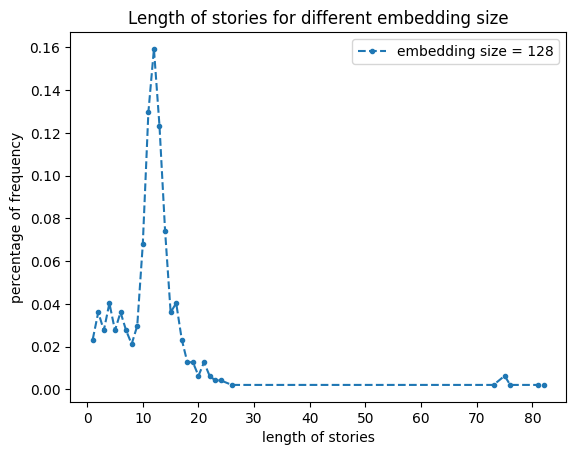

In [286]:

freq = [w/total for w in list(t.values())]
plt.plot(list(t.keys()), freq, '--.', label='embedding size = 128')
plt.xlabel("length of stories")
plt.ylabel("percentage of frequency")
plt.title("Length of stories for different embedding size")
plt.legend()
plt.show()

[13, 4, 6, 6, 13, 12, 17, 14, 6, 19, 16, 3, 3, 12, 4, 11, 17, 11, 15, 14, 5, 11, 7, 13, 11, 18, 23, 12, 13, 21, 5, 17, 12, 13, 14, 18, 24, 11, 10, 3, 21, 14, 11, 2, 13, 1, 13, 12, 3, 6, 14, 10, 13, 11, 1, 14, 14, 14, 15, 13, 11, 16, 12, 13, 13, 2, 20, 11, 15, 19, 13, 12, 11, 13, 11, 12, 13, 14, 7, 14, 12, 2, 16, 12, 16, 11, 13, 17, 15, 17, 82, 13, 13, 2, 11, 5, 12, 12, 19, 12, 6, 13, 16, 17, 17, 11, 17, 16, 12, 14, 13, 18, 8, 4, 14, 1, 12, 15, 12, 18, 12, 14, 14, 14, 6, 14, 11, 11, 2, 13, 12, 12, 19, 17, 14, 12, 12, 5, 13, 9, 10, 9, 11, 14, 12, 12, 10, 12, 3, 10, 11, 11, 15, 13, 12, 10, 10, 18, 8, 8, 10, 14, 7, 11, 11, 13, 12, 7, 14, 6, 1, 13, 12, 16, 15, 13, 13, 11, 13, 13, 13, 15, 2, 12, 2, 1, 13, 15, 12, 81, 13, 15, 5, 11, 7, 21, 11, 5, 10, 13, 16, 12, 11, 6, 12, 6, 13, 6, 16, 19, 12, 10, 12, 14, 12, 11, 12, 24, 5, 7, 1, 13, 2, 22, 14, 13, 11, 13, 12, 12, 12, 1, 21, 11, 13, 5, 12, 8, 12, 14, 3, 11, 12, 13, 1, 12, 5, 10, 13, 4, 12, 11, 10, 13, 11, 13, 4, 7, 14, 3, 12, 7, 13, 12, 12, 

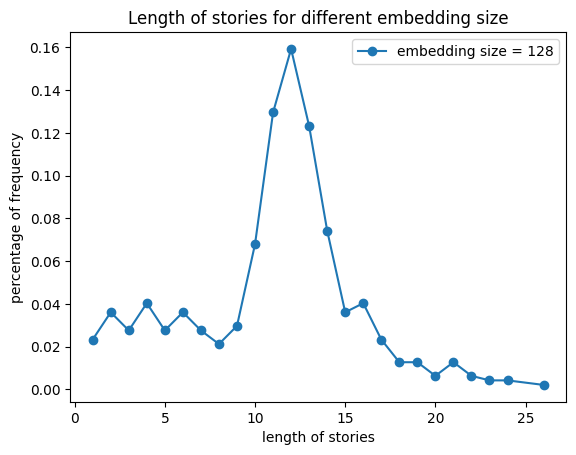

In [242]:
t = length_story_frequency(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128)
total = len(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128)
freq = [w/total for w in list(t.values())][:25]
plt.plot(list(t.keys())[:25], freq, '--.', label='embedding size = 128')
plt.xlabel("length of stories")
plt.ylabel("percentage of frequency")
plt.title("Length of stories for different embedding size")
plt.legend()
plt.show()

[23, 4, 6, 6, 19, 16, 79, 53, 6, 83, 45, 3, 3, 29, 4, 15, 77, 59, 65, 36, 5, 20, 7, 64, 11, 85, 78, 12, 44, 72, 5, 76, 61, 49, 46, 39, 71, 22, 39, 3, 76, 29, 29, 2, 69, 1, 75, 54, 3, 6, 40, 12, 15, 17, 1, 41, 21, 53, 30, 31, 12, 80, 14, 56, 15, 2, 29, 71, 83, 70, 34, 66, 68, 22, 36, 72, 7, 69, 17, 2, 55, 13, 14, 56, 83, 26, 82, 53, 30, 2, 13, 5, 22, 64, 36, 12, 6, 22, 34, 40, 11, 36, 82, 25, 28, 65, 8, 4, 40, 1, 44, 18, 15, 32, 50, 43, 6, 20, 13, 2, 18, 12, 80, 29, 31, 21, 5, 65, 9, 10, 21, 40, 27, 11, 24, 3, 10, 16, 11, 15, 82, 30, 12, 28, 30, 8, 8, 10, 19, 11, 25, 18, 59, 7, 51, 6, 1, 64, 46, 47, 84, 26, 28, 18, 38, 61, 41, 38, 2, 47, 2, 1, 74, 58, 21, 82, 5, 18, 7, 13, 5, 14, 38, 75, 17, 12, 6, 57, 6, 6, 36, 85, 29, 61, 26, 77, 44, 13, 5, 7, 1, 40, 2, 26, 52, 48, 20, 49, 15, 16, 18, 1, 84, 16, 63, 5, 27, 8, 34, 15, 3, 11, 33, 38, 1, 32, 5, 15, 40, 4, 15, 30, 18, 21, 4, 7, 60, 3, 7, 26, 27, 35, 17, 17, 5, 10, 9, 4, 5, 2, 8, 37, 12, 19, 13, 11, 35, 33, 16, 8, 17, 35, 75, 43, 22, 14, 3

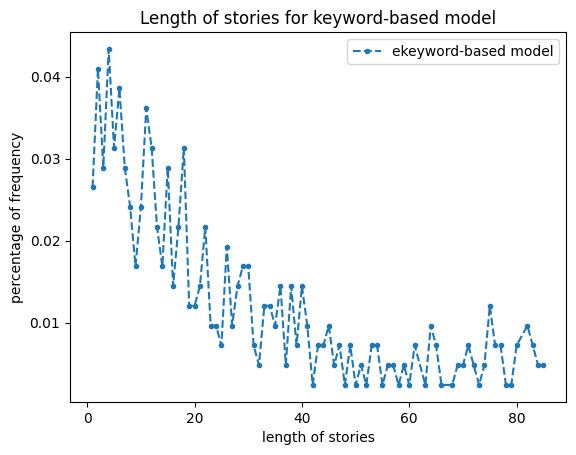

In [272]:
t_keyword = length_story_frequency(result_dict_story_gen_just_tfidf_novel_method_v128)
total_k = len(result_dict_story_gen_just_tfidf_novel_method_v128)
freq_k = [w/total_k for w in list(t_keyword.values())]
plt.plot(list(t_keyword.keys()), freq_k, '--.', label='ekeyword-based model')
plt.xlabel("length of stories")
plt.ylabel("percentage of frequency")
plt.title("Length of stories for keyword-based model")
plt.legend()
plt.show()

[1, 1, 15, 2, 1, 1, 31, 32, 15, 34, 2, 1, 31, 15, 26, 33, 24, 19, 1, 23, 7, 23, 49, 1, 1, 1, 13, 1, 24, 1, 1, 13, 1, 1, 28, 1, 27, 1, 33, 1, 1, 1, 1, 1, 1, 19, 40, 20, 35, 1, 20, 1, 1, 38, 1, 2, 1, 35, 27, 5, 60, 1, 1, 3, 1, 37, 67, 1, 38, 1, 1, 4, 1, 9, 8, 12, 2, 1, 1, 42, 13, 1, 1, 3, 22, 24, 14, 22, 2, 1, 1, 1, 3, 1, 22, 26, 1, 1, 26, 15, 38, 29, 27, 29, 11, 21, 29, 20, 23, 26, 28, 28, 18, 33, 15, 24, 29, 38, 34, 38, 18, 61, 31, 37, 15, 37, 20, 32, 25, 38, 38, 33, 27, 34, 6, 27, 30, 32, 24, 18, 64, 27, 32, 21, 31, 63, 23, 14, 29, 17, 37, 19, 15, 15, 12, 31, 25, 18, 34, 24, 18, 29, 64, 23, 35, 8, 42, 35, 21, 32, 40, 13, 37, 19, 23, 34, 24, 12, 29, 19, 34, 15, 15, 24, 22, 66, 24, 34, 21, 9, 32, 29, 34, 32, 32, 33, 60, 10, 21, 37, 31, 43, 25, 13, 32, 39, 32, 30, 27, 29, 33, 18, 23, 23, 29, 28, 8, 27, 39, 13, 29, 60, 22, 1, 30, 22, 19, 32, 13, 11, 22, 32, 34, 37, 19, 27, 30, 27, 28, 22, 38, 12, 4, 33, 5, 62, 27, 37, 33, 29, 25, 64, 39, 27, 10, 25, 25, 33, 33, 24, 24, 22, 2, 28, 20, 23, 

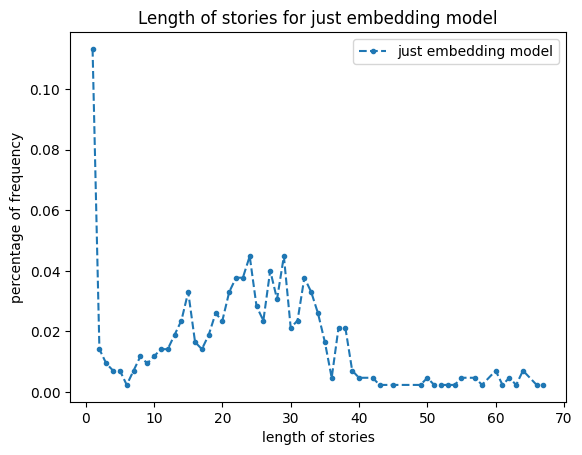

In [288]:
# for just embedding model
t_emb = length_story_frequency(result_dict_story_gen_just_emb_novel_method)
total_emb= len(result_dict_story_gen_just_emb_novel_method)
freq_emb = [w/total_emb for w in list(t_emb.values())]
plt.plot(list(t_emb.keys()), freq_emb, '--.', label='just embedding model')
plt.xlabel("length of stories")
plt.ylabel("percentage of frequency")
plt.title("Length of stories for just embedding model")
plt.legend()
plt.show()

In [71]:
#dispersion metric
teta_list = [w/100 for w in range(60,98,2)]

In [72]:
def disp(d_i, d_j, n, teta, i, j):
  a = contextual_dict[d_i]
  b = contextual_dict[d_j]
  dist = cosine_similarity([a],[b])[0][0]
  if dist < teta:
    return 1/(n+i-j)
  else:
    return 0

In [73]:
def final_disp(story_, teta):
  res = list()
  len_story = len(story_)
  for i in range(len_story-3):
    for j in range(i+2, len_story-1):
      res.append(disp(story_[i], story_[j], len_story, teta, i, j))

  return 1.0 - (sum(res)/(len_story-2 + 0.01))

In [103]:
def dispersion_metric(stories):
    disp_values = list()
    for te_ta in tqdm(teta_list):
      g_value = [final_disp(stories[x], te_ta) for x in stories]
      disp_values.append(sum(g_value)/ len(g_value))
    return disp_values
    

In [173]:
# z is the dispersion value for different thresholds of theta
z = dispersion_metric(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128)

100%|██████████| 19/19 [02:54<00:00,  9.19s/it]


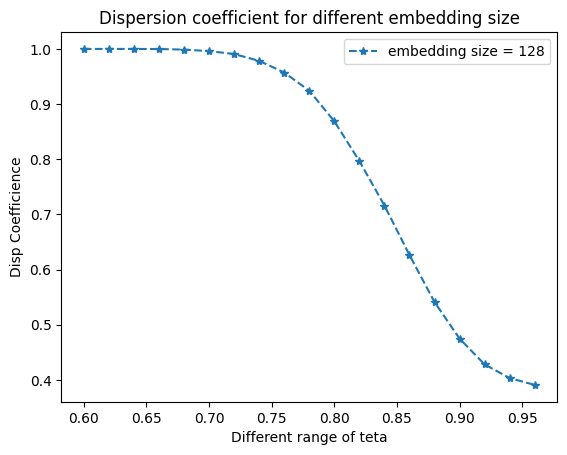

In [245]:
plt.plot(teta_list, z, '--*', label='embedding size = 128')
plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for different embedding size")
plt.legend()
plt.show()

In [246]:
print('dispersion value for vector size 128 is:', z[10]) #10 is the median

dispersion value for vector size 128 is: 0.8688055832895287


100%|██████████| 19/19 [16:19<00:00, 51.53s/it]


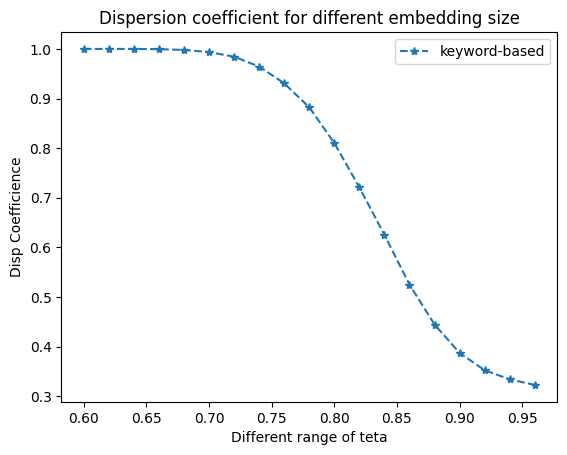

dispersion value for keyword-based is: 0.8102411256204679


In [289]:
#dispersion for keyword based model
# result_dict_story_gen_just_tfidf_novel_method_v128
z_keywords = dispersion_metric(result_dict_story_gen_just_tfidf_novel_method_v128)
plt.plot(teta_list, z_keywords, '--*', label='keyword-based')
plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for different embedding size")
plt.legend()
plt.show()
print('dispersion value for keyword-based is:', z_keywords[10]) #10 is the median

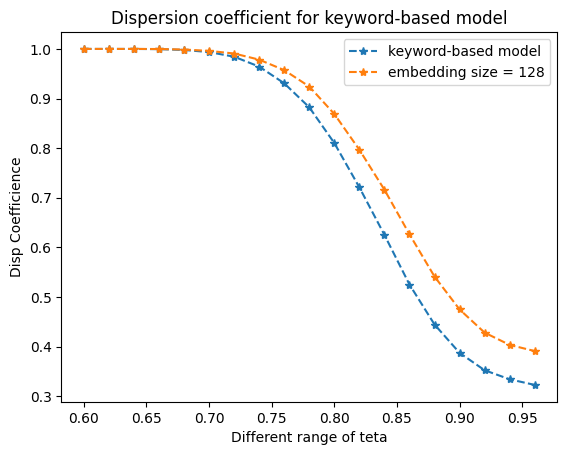

dispersion value for keyword-based is: 0.8102411256204679


In [267]:
plt.plot(teta_list, z_keywords, '--*', label='keyword-based model')
plt.plot(teta_list, z, '--*', label='embedding size = 128')
plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for different model")
plt.legend()
plt.show()
print('dispersion value for keyword-based is:', z_keywords[10]) #10 is the median

100%|██████████| 19/19 [09:30<00:00, 30.03s/it]


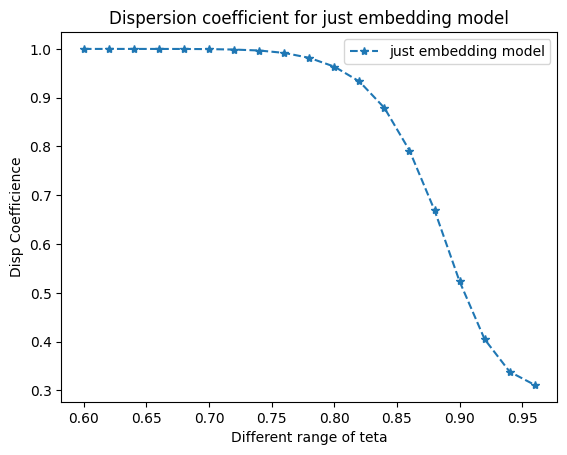

dispersion value for just embedding model is: 0.9637244102397906


In [295]:
# just embedding model
# result_dict_story_gen_just_emb_novel_method
z_emb = dispersion_metric(result_dict_story_gen_just_emb_novel_method)
plt.plot(teta_list, z_emb, '--*', label='just embedding model')
plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for just embedding model")
plt.legend()
plt.show()
print('dispersion value for just embedding model is:', z_emb[10]) #10 is the median

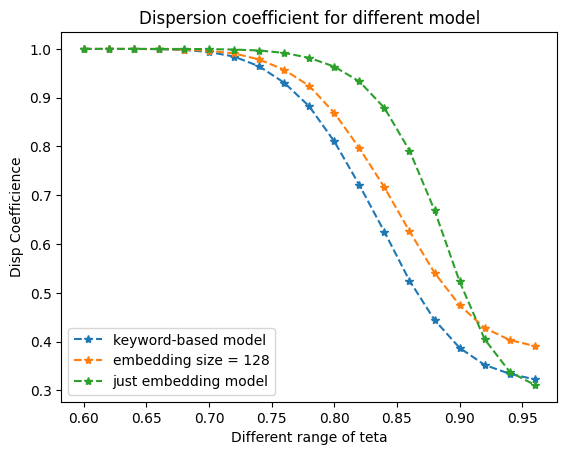

In [296]:
plt.plot(teta_list, z_keywords, '--*', label='keyword-based model')
plt.plot(teta_list, z, '--*', label='embedding size = 128')
plt.plot(teta_list, z_emb, '--*', label='just embedding model')

plt.xlabel("Different range of teta")
plt.ylabel("Disp Coefficience")
plt.title("Dispersion coefficient for different model")
plt.legend()
plt.show()

In [106]:
#SEC metric, story evaluation coefficient
# def story_evaluation_vec (stories_embedding, t_max):
#   n_stories = len(stories_embedding)
#   res = list()
#   for story in stories_embedding:
#     temp_res = list()
#     for i in range(len(story)-1):
#       temp = cosine_similarity([story[i]], [story[i+1]])[0][0]
#       temp_res.append(  (10*t_max - 10*temp + 1)* np.exp( -10*(t_max - temp))   )
#     res.append(np.average(temp_res))
#   return res

In [248]:
def story_evaluation_avg (stories, t_max):
    n_stories = len(stories)
    res = list()
    for story_id in stories:
        if len(stories[story_id])<2:
            continue
        temp_res = list()
        for i in range(len(stories[story_id])-1):
          temp = cosine_similarity([contextual_dict[stories[story_id][i]]], [contextual_dict[stories[story_id][i+1]]])[0][0]
          temp_res.append((10*t_max - 10*temp + 1)* np.exp( -10*(t_max - temp)))
        res.append(np.average(temp_res))
    return np.average(res)

In [274]:
thre = [w/100 for w in range(80,99,1)]
sec_res = []
for t_max in tqdm(thre):
    sec_res.append(story_evaluation_avg(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128, t_max))

100%|██████████| 19/19 [00:23<00:00,  1.21s/it]


In [275]:
max(sec_res)

0.8718642096079855

In [276]:
print('Story Evaluation Coefficient for proposed model', max(sec_res))

Story Evaluation Coefficient for proposed model 0.8718642096079855


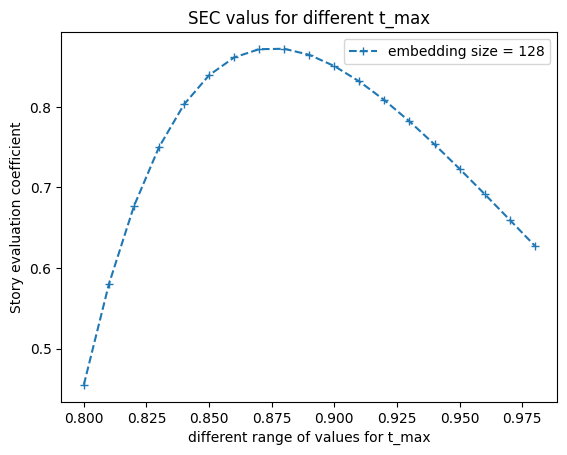

In [277]:
plt.plot(thre, sec_res, '--+', label='embedding size = 128')
plt.xlabel("different range of values for t_max")
plt.ylabel("Story evaluation coefficient")
plt.title("SEC valus for different t_max")
plt.legend()
plt.show()

In [278]:
# sec for keyword based model
thre = [w/100 for w in range(80,99,1)]
sec_res_keyword = []
for t_max in tqdm(thre):
    sec_res_keyword.append(story_evaluation_avg(result_dict_story_gen_just_tfidf_novel_method_v128, t_max))

100%|██████████| 19/19 [00:49<00:00,  2.61s/it]


In [279]:
print('Story Evaluation Coefficient for keyword-based model model', max(sec_res_keyword))

Story Evaluation Coefficient for keyword-based model model 0.8573631513734922


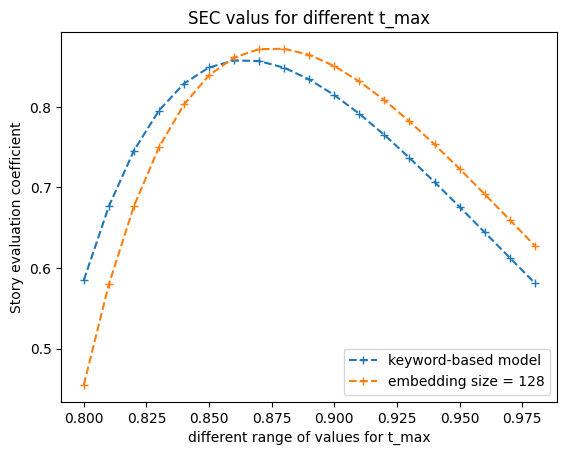

In [281]:
plt.plot(thre, sec_res_keyword, '--+', label='keyword-based model')
plt.plot(thre, sec_res, '--+', label='embedding size = 128')
plt.xlabel("different range of values for t_max")
plt.ylabel("Story evaluation coefficient")
plt.title("SEC valus for different t_max")
plt.legend()
plt.show()

In [297]:
# for just embedding model
# result_dict_story_gen_just_emb_novel_method

thre = [w/100 for w in range(80,99,1)]
sec_res_emb = []
for t_max in tqdm(thre):
    sec_res_emb.append(story_evaluation_avg(result_dict_story_gen_just_emb_novel_method, t_max))
print('Story Evaluation Coefficient for just embedding model', max(sec_res_emb))

100%|██████████| 19/19 [00:40<00:00,  2.16s/it]

Story Evaluation Coefficient for just embedding model 0.9698322116196343


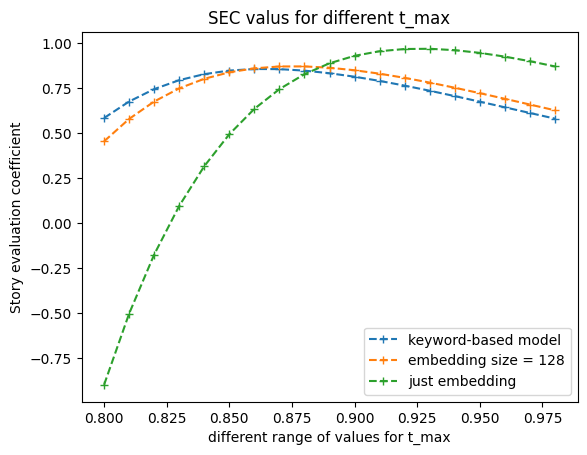

In [298]:
plt.plot(thre, sec_res_keyword, '--+', label='keyword-based model')
plt.plot(thre, sec_res, '--+', label='embedding size = 128')
plt.plot(thre, sec_res_emb, '--+', label='just embedding')

plt.xlabel("different range of values for t_max")
plt.ylabel("Story evaluation coefficient")
plt.title("SEC valus for different t_max")
plt.legend()
plt.show()

In [ ]:
# Hit@K metric

In [133]:
def keyword_extractor(x_tf_idf_, list_of_words_in_tfidf_, top_keywords_):
    temp_dict = dict()
    for i,j in zip(x_tf_idf_, list_of_words_in_tfidf_):
        temp_dict[j] = i
    return sorted(temp_dict.items(), key=lambda x:x[1], reverse=True)[:top_keywords_]

In [ ]:
# keyword_extractor(tf_idf_dict[seed_doc], list_of_words_in_tfidf, 100)

In [218]:
# in generates a hit@k for each story in stories. to get the final value, the outcome must be get averaged
def hit(stories, k):
    res = []
    for story_id in stories:
        if len(stories[story_id])<2:
            continue
        res_per_story = 0
        for i in range(len(stories[story_id])-1):
            key_1 = set([w[0] for w in keyword_extractor(tf_idf_dict[stories[story_id][i]], list_of_words_in_tfidf, 10*k)])
            key_2 = set([w[0] for w in keyword_extractor(tf_idf_dict[stories[story_id][i+1]], list_of_words_in_tfidf, 10*k)])
            if len(key_1.intersection(key_2))>0:
                res_per_story += 1
        res_per_story = res_per_story/(len(stories[story_id])-1)
        res.append(res_per_story)
    return res 

In [219]:
l_1 = hit(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128,1)
l_3 = hit(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128,3)
l_5 = hit(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128,5)

In [282]:
print('for embedding size of 128 the porposed model')
print(np.average(l_1))
print(np.average(l_3))
print(np.average(l_5))

for embedding size of 128 the porposed model
0.3984849497653377
0.6400613391343518
0.8068462095611321


In [ ]:
# derawing a graph with entity-overlap vs story length for different rank-k

In [300]:
# for keyword based model
l_1_keyword = hit(result_dict_story_gen_just_tfidf_novel_method_v128,1)
l_3_keyword = hit(result_dict_story_gen_just_tfidf_novel_method_v128,3)
l_5_keyword = hit(result_dict_story_gen_just_tfidf_novel_method_v128,5)
print('for keyword-based model')
print(np.average(l_1_keyword))
print(np.average(l_3_keyword))
print(np.average(l_5_keyword))

for keyword-based model
0.3688378066004517
0.6186160275445148
0.7949220426290892


for keyword-based model
0.3688378066004517
0.6186160275445148
0.7949220426290892


In [299]:
# for just embedding model
result_dict_story_gen_just_emb_novel_method
l_1_emb = hit(result_dict_story_gen_just_emb_novel_method,1)
l_3_emb = hit(result_dict_story_gen_just_emb_novel_method,3)
l_5_emb = hit(result_dict_story_gen_just_emb_novel_method,5)
print('for just embedding model')
print(np.average(l_1_emb))
print(np.average(l_3_emb))
print(np.average(l_5_emb))

for just embedding model
0.16110868411090004
0.347237189284662
0.553287218973561


In [229]:
def hit_per_story(story, k):
    if len(story)<2:
        return 0
    res_per_story = 0
    for i in range(len(story)-1):
        key_1 = set([w[0] for w in keyword_extractor(tf_idf_dict[story[i]], list_of_words_in_tfidf, 10*k)])
        key_2 = set([w[0] for w in keyword_extractor(tf_idf_dict[story[i+1]], list_of_words_in_tfidf, 10*k)])
        if len(key_1.intersection(key_2))>0:
            res_per_story += 1
    return res_per_story/(len(story)-1)

In [223]:
length_rank_dict = dict()
for i in range(100):
    length_rank_dict[i] = []
for i in result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128:
    length_rank_dict[len(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128[i])].append(hit_per_story(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128[i], 1))
    
for i in range(100):
    length_rank_dict[i] = np.average(length_rank_dict[i]) 

460

100%|██████████| 3/3 [03:18<00:00, 66.12s/it]


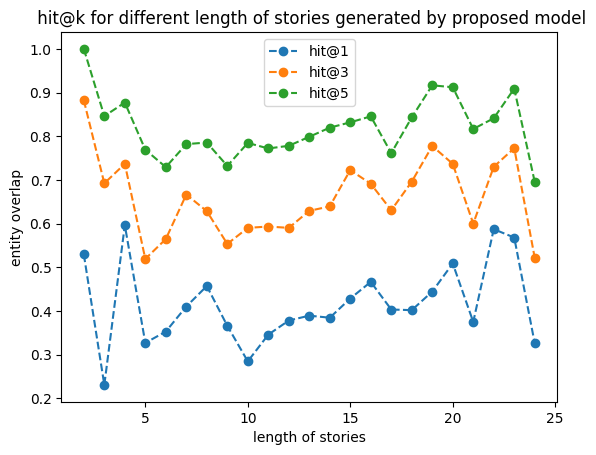

In [239]:
for k in tqdm([1,3,5]):
    length_rank_dict = dict()
    for i in range(100):
        length_rank_dict[i] = []
    for i in result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128:
        length_rank_dict[len(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128[i])].append(hit_per_story(result_dict_story_gen_emb_tfidf_novel_method_w_distributed_attention_v128[i], k))
        
    for i in range(100):
        length_rank_dict[i] = np.average(length_rank_dict[i]) 
    x_array = list(length_rank_dict.keys())[2:25]
    y_array = [length_rank_dict[w] for w in x_array]
    plt.plot(x_array, y_array, '--o', label='hit@{}'.format(k))
plt.xlabel("length of stories")
plt.ylabel("entity overlap")
plt.title(" hit@k for different length of stories generated by proposed model")
plt.legend()
plt.show()

471